General imports

In [212]:
import pandas as pd
import matplotlib.pyplot as plt
from pylab import rcParams
import statsmodels.api as sm
from joblib import Parallel, delayed
from multiprocessing import cpu_count

Reading dataset

In [186]:
df = pd.read_csv('GlobalLandTemperaturesByCountry.csv')

Quick view to the data

In [187]:
df.head()
df = df.dropna()

In [188]:
# from pandas_profiling import ProfileReport
# profile = ProfileReport(df)
# profile

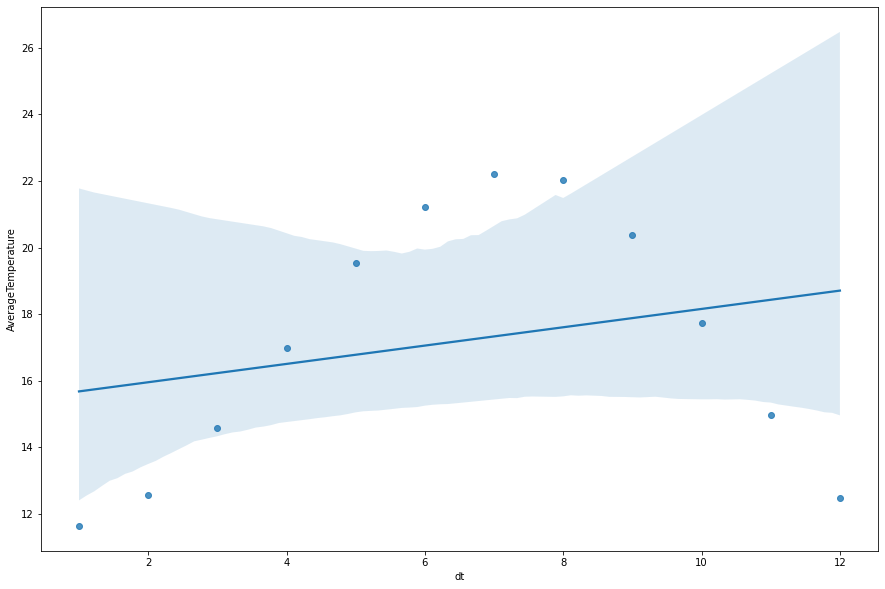

In [189]:
df['dt'] = pd.to_datetime(df['dt'])
monthlyDF = df.groupby(df['dt'].dt.strftime('%m'))['AverageTemperature'].mean().sort_values().reset_index(name='AverageTemperature')
# monthlyDF
monthlyDF = monthlyDF.sort_values('dt')
monthlyDF.rename(columns={0 : 'AverageTemperature'}, inplace=True)
monthlyDF['AverageTemperature'] = monthlyDF['AverageTemperature'].apply(lambda x: float(x))
monthlyDF['dt'] = monthlyDF['dt'].apply(lambda x: float(x))
sns.regplot(x=monthlyDF["dt"], y=monthlyDF["AverageTemperature"])
plt.show()

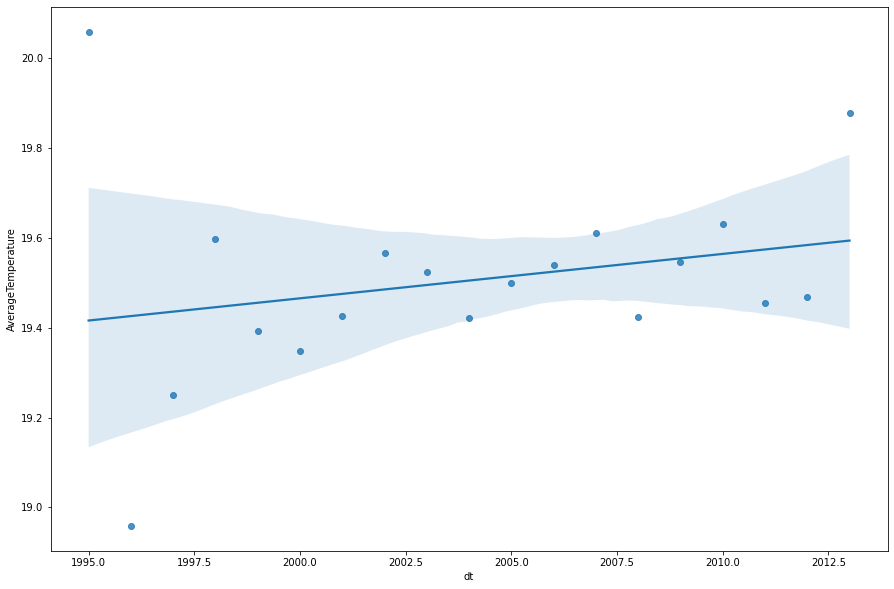

In [190]:
df['dt'] = pd.to_datetime(df['dt'])
last20YearsDF = df[(df['dt'] > '1995-06-01') & (df['dt'] < '2014-01-01')]
last20YearsDF = (last20YearsDF.groupby(df['dt'].dt.strftime('%Y'))['AverageTemperature'].mean().sort_values().reset_index(name='AverageTemperature'))
last20YearsDF = last20YearsDF.sort_values('dt')
last20YearsDF.rename(columns={0 : 'AverageTemperature'}, inplace=True)
last20YearsDF['AverageTemperature'] = last20YearsDF['AverageTemperature'].apply(lambda x: float(x))
last20YearsDF['dt'] = last20YearsDF['dt'].apply(lambda x: float(x))
sns.regplot(x=last20YearsDF["dt"], y=last20YearsDF["AverageTemperature"])
plt.show()

<AxesSubplot:>

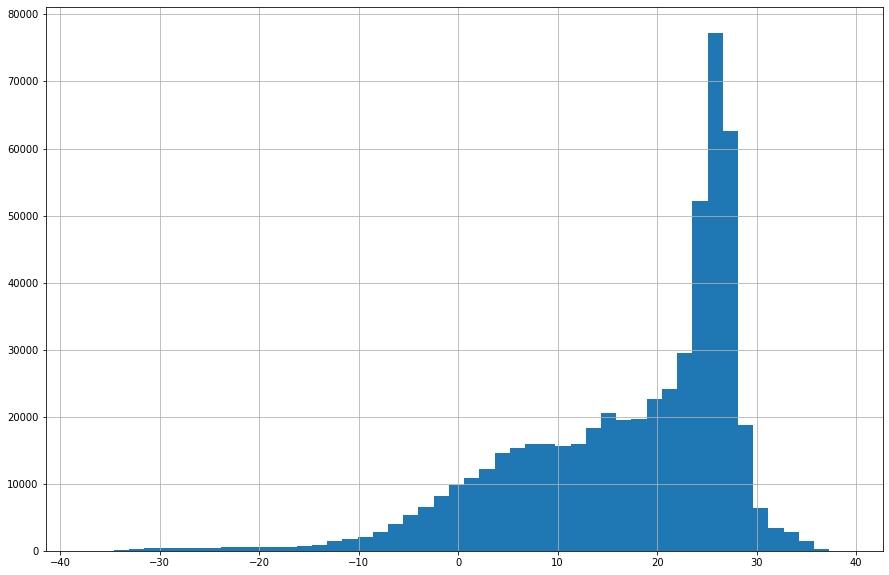

In [191]:
#2a.

df['AverageTemperature'].hist(bins=50)

<AxesSubplot:xlabel='dt', ylabel='AverageTemperature'>

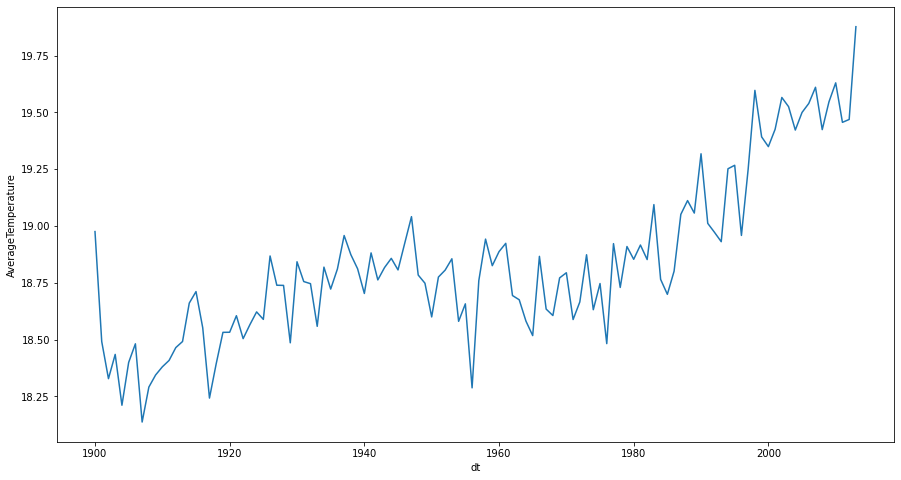

In [192]:
#2b

df['dt'] = pd.to_datetime(df['dt'])
last20YearsDF = df[(df['dt'] > '1900-01-01')]
last20YearsDF = (last20YearsDF.groupby(df['dt'].dt.strftime('%Y'))['AverageTemperature'].mean().sort_values().reset_index(name='AverageTemperature'))
last20YearsDF = last20YearsDF.sort_values('dt')
last20YearsDF.rename(columns={0 : 'AverageTemperature'}, inplace=True)
last20YearsDF['AverageTemperature'] = last20YearsDF['AverageTemperature'].apply(lambda x: float(x))
last20YearsDF['dt'] = last20YearsDF['dt'].apply(lambda x: float(x))
plt.figure(figsize = (15,8))
sns.lineplot(x=last20YearsDF["dt"], y=last20YearsDF["AverageTemperature"])

# plt.show()

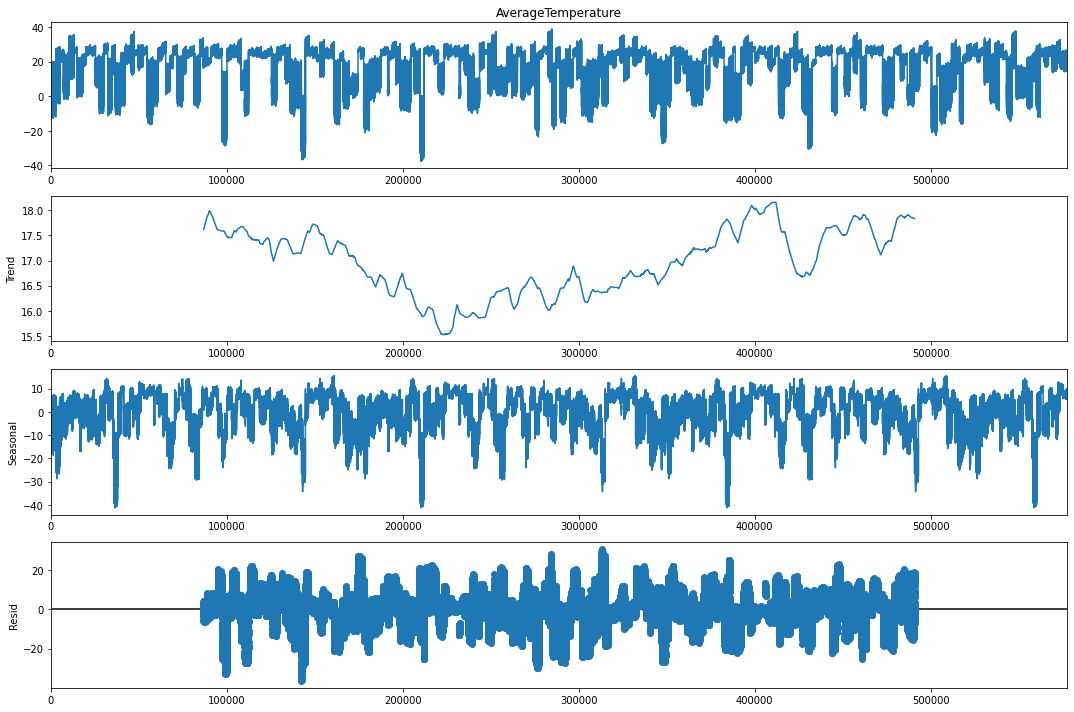

In [193]:
#2c

rcParams['figure.figsize'] = 15, 10

decomposition = sm.tsa.seasonal_decompose(df['AverageTemperature'],model='additive', period=164409)
                                                  
fig = decomposition.plot()
plt.show()

In [194]:
#2d 

# No es neecsario por la calidad de los datos

In [195]:
#2e

In [196]:
#2f

def division_entreno_prueba(datos, n_prueba):
    return datos[:-n_prueba], datos[-n_prueba:]

def medir_rmse(actual, predicho):
    return sqrt(mean_squared_error(actual, predicho))

# validación "walk-forward" para datos univariados
def validacion_al_frente(datos, n_prueba, metodo, cfg):
    predicciones = []
    # dividir el conjunto de datos
    entreno, prueba = division_entreno_prueba(datos, n_prueba)
    # grabar la historia con el conjunto de datos de entrenamiento
    historia = [x for x in entreno]
    # pasar por cada incremento de tiempo en el conjunto de prueba
    for i in range(len(prueba)):
        # ajustar el modelo a los datos y predecir los datos históricos
        if metodo == "promedio":
            yhat = prediccion_promedio(historia, cfg)
        elif metodo == "sarima":
            yhat = prediccion_sarima(historia, cfg)
        elif metodo == "exp":
            yhat = prediccion_alisamiento_exp(historia, cfg)
        # agregar el dato predicho en la lista de preducciones
        predicciones.append(yhat)
        # agregar la observación a la historia para la siguiente iteración
        historia.append(prueba[i])
    # estimar el error de las predicciones
    error = medir_rmse(prueba, predicciones)
    return [error, predicciones]

def busqueda_malla(datos, lista_cfg, n_prueba, metodo = "sarima", paralelo = True):
    resultados = None
    if paralelo:
        # ejecutar las configuraciones en paralelo
        executor = Parallel(n_jobs = cpu_count(), backend = 'multiprocessing') 
        tareas = (delayed(calificar_modelo)(datos, n_prueba, metodo, cfg) for cfg in lista_cfg) 
        resultados = executor(tareas)
    else:
        resultados = [calificar_modelo(datos, n_prueba, metodo, cfg) for cfg in lista_cfg]
    # eliminar resultados vacíos
    resultados = [r for r in resultados if r[1] != None]
    return resultados

def calificar_modelo(datos, n_prueba, metodo, cfg, debug = False):
    resultado = None
    predicciones = None
    # convertir la confiuración a una llave
    llave = str(cfg)
    if debug:
        resultado, predicciones = validacion_al_frente(datos, n_prueba, metodo, cfg)
    else:
        # una falla durante la validación del modelo sugiere una configuración inestable
        try:
        # nunca mostrar advertencias cuando se busca en malla...demasiado "ruido"
            with catch_warnings():
                filterwarnings("ignore")
                resultado, predicciones = validacion_al_frente(datos, n_prueba, metodo, cfg)
        except:
            error = None
    if resultado is not None:
        print(f' > Modelo{llave} {resultado:.3f}')
    return (llave, resultado, predicciones)

def encontrar_mejor_solucion(series, nombre, metodo = "sarima", muestra = False):
    datos = series.values
    resultados = []
    # dividir los datos
    n_prueba = int(len(datos) * 0.2) # porcenta usado para prueba
    long_max = len(datos) - n_prueba
    print(f"Tamaño Entrenamiento {long_max}")
    print(f"Tamaño Prueba {n_prueba}")

    # configuraciones de los modelos
    if metodo == "sarima":
        print(f"Encontrando la mejor solución para {metodo}")
        lista_cfg = config_sarima()
    elif metodo == "promedio":
        print(f"Encontrando la mejor solución para {metodo}")
        lista_cfg = config_simple(long_max)
    elif metodo == "exp":
        print(f"Encontrando la mejor solución para {metodo}")
        lista_cfg = config_alisamiento_exp()
        datos = datos[:,0]
    # muestrear algunos
    if muestra:
        lista_cfg_azar = random.sample(lista_cfg, k = 25)
        while len(resultados) < 5:
            lista_cfg_azar = random.sample(lista_cfg, k = 25)
            resultados += busqueda_malla(datos, lista_cfg_azar, n_prueba, metodo)
    else:
        # búsqueda en malla
              
        # Si se tiene capacidad de procesamiento paralelo, paralelo = True (default)
        paralelo = True
        resultados = busqueda_malla(datos, lista_cfg, n_prueba, metodo, paralelo)
        
    
    # ordenan las configuraciones por error, ascendente
    resultados.sort(key = lambda tup: tup[1])

    print('terminado')
    # listar las mejores 3 configuraciones
    for cfg, error, predicciones in resultados[:3]:
        print(cfg, error)

    # desplegar
    entreno, prueba = division_entreno_prueba(datos, n_prueba)
    prediccion = pd.DataFrame(list(entreno.flatten()) + resultados[0][2])
    ax = pd.DataFrame(datos).plot(label = "Original") # Datos originales
    prediccion.plot(ax = ax, alpha = .7, figsize = (14,7))
    # Esconder las líneas de malla de la gráfica
    # ax.grid(False)

    # Esconder las marcas en los ejes
    #ax.set_xticks([])
    #ax.set_yticks([])
    
    plt.savefig(f"{nombre}_{metodo}.png", transparent = True)
    plt.show()

def prediccion_sarima(historia, config):
    orden, orden_estacional, tendencia = config
    # definir el modelo
    modelo = SARIMAX(historia, order = orden, seasonal_order = orden_estacional, trend = tendencia,
      enforce_stationarity = False, enforce_invertibility = False)
    # ajustar el model con los datos
    modelo_ajustado = modelo.fit(disp = False)
    # hacer la predicción de un paso
    yhat = modelo_ajustado.predict(len(historia), len(historia))
    return yhat[0]

def config_sarima(estacional = [0]):
    modelos = []
    # definir las listas de configuración
    p_params = [0, 1, 2]
    d_params = [0, 1]
    q_params = [0, 1, 2]
    t_params = ['n','c','t','ct'] 
    P_params = [0, 1, 2]
    D_params = [0, 1]
    Q_params = [0, 1, 2]
    m_params = estacional
    # crear instancias de configuración
    for p in p_params:
        for d in d_params:
            for q in q_params:
                for t in t_params:
                    for P in P_params:
                        for D in D_params:
                            for Q in Q_params:
                                for m in m_params:
                                    cfg = [(p,d,q), (P,D,Q,m), t]
                                    modelos.append(cfg)
    return modelos

In [207]:

sarimaDF = df[["dt", "AverageTemperature"]]
sarimaDF = sarimaDF[(sarimaDF['dt'] > '2010-01-01')]
sarimaDF = sarimaDF.groupby(['dt']).mean()
sarimaDF


,AverageTemperature
dt,
2010-02-01,16.043248
2010-03-01,18.040702
2010-04-01,19.891855
2010-05-01,21.687194
2010-06-01,22.998525
2010-07-01,23.788690
2010-08-01,23.576074
2010-09-01,22.067554
2010-10-01,19.883388


In [213]:
nombre = 'AverageTemperature'
encontrar_mejor_solucion(sarimaDF, nombre, metodo = "sarima")

Tamaño Entrenamiento 36
Tamaño Prueba 8
Encontrando la mejor solución para sarima
